In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
from scipy.optimize import curve_fit

sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer
from scalar_features import ScalarFeaturizer
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils

%load_ext autoreload
%autoreload 2

In [2]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'
# sim_name = 'TNG50-4'
# sim_name_dark = 'TNG50-4-Dark'
halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin1'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = '_xminPE'
fn_geo_features = f'{geo_dir}/geometric_features{halo_tag}{geo_tag}.npy'

In [4]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [5]:
n_groups = [[0,1,2], [3,4,5,6,7]]
geo_feature_arr_rebinned = utils.rebin_geometric_features(geo_featurizer.geo_feature_arr, n_groups)

In [6]:
sim_reader = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')

In [7]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)

## Set up general scalar featurizer

In [25]:
# scalar info
scalar_featurizer = ScalarFeaturizer(geo_feature_arr_rebinned)
scalar_featurizer.compute_MXV_from_features()
scalar_featurizer.rescale_geometric_features(scalar_featurizer.M_tot, 
                                             scalar_featurizer.X_rms, 
                                             scalar_featurizer.V_rms)
# m_dm is in units of 1/1e10, this M_tot value is already in the units we're using internally (log(M/1e10))
x_features_extra = np.vstack((scalar_featurizer.M_tot, 
                              scalar_featurizer.X_rms,
                              scalar_featurizer.V_rms)).T
x_features_extra = np.log10(x_features_extra)   

## Uncertainties & powerlaw

In [19]:
uncertainties_genel2019 = utils.get_uncertainties_genel2019(log_m_stellar+log_mass_shift, sim_name=sim_name)

In [20]:
# maybe a better way to do this, but just logging for now to be consistent
def broken_power_law(log_M200, N=1, log_M1=12-log_mass_shift, beta=1, gamma=1):
    return log_M200 + np.log10( 2*N/((log_M200/log_M1)**(-beta) + (log_M200/log_M1)**gamma) )

In [21]:
M1 = 12-log_mass_shift
p0 = [0.01, M1, 1.5, 0.4]
bounds = [[0]*len(p0), [np.inf]*len(p0)]
popt, _ = curve_fit(broken_power_law, log_m_200m, log_m_stellar, sigma=uncertainties_genel2019, 
                    bounds=bounds, p0=p0)
y_val_current_powerlaw_fit = broken_power_law(log_m_200m, *popt)

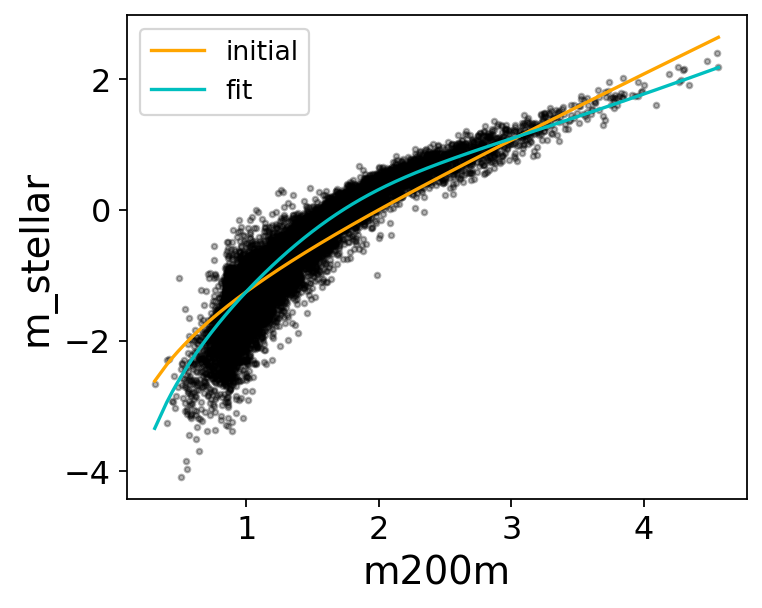

In [22]:
plt.figure(figsize=(5,4))
# sort for plotting niceness
idx_m_200m = np.argsort(log_m_200m)
y_initial = broken_power_law(log_m_200m, *p0)
plt.scatter(log_m_200m[idx_m_200m], log_m_stellar[idx_m_200m], s=6, c='k', alpha=0.3)
plt.plot(log_m_200m[idx_m_200m], y_initial[idx_m_200m], color='orange', label='initial')
plt.plot(log_m_200m[idx_m_200m], y_val_current_powerlaw_fit[idx_m_200m], color='c', label='fit')
plt.xlabel('m200m')
plt.ylabel('m_stellar')
plt.legend(fontsize=12)

### Baseline: MXV + powerlaw + const

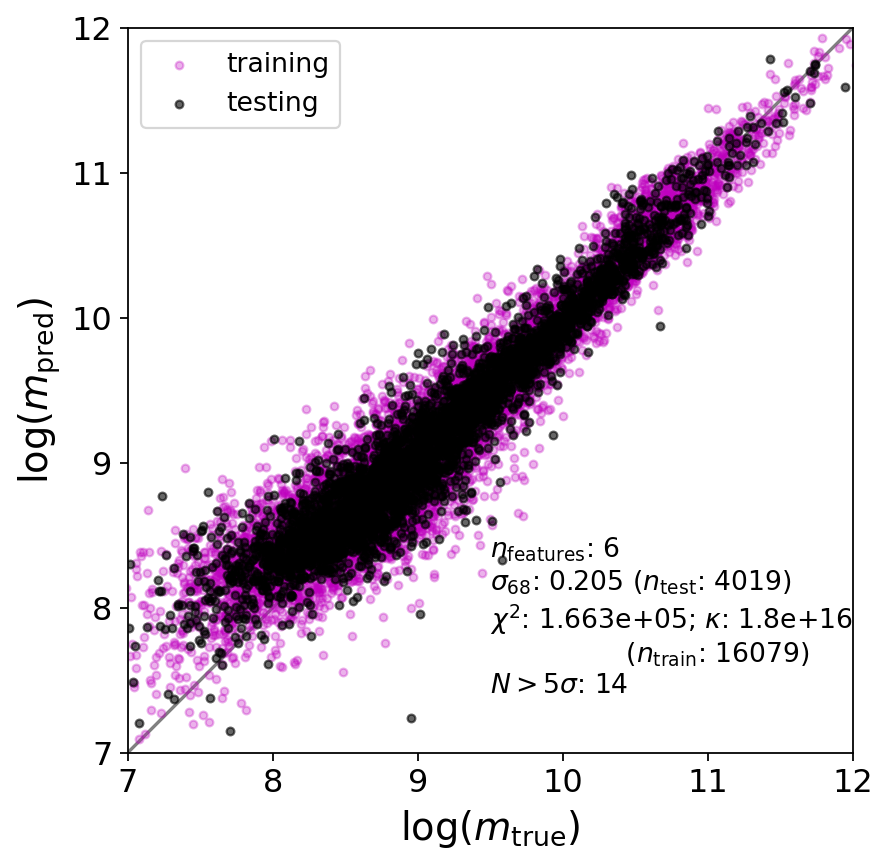

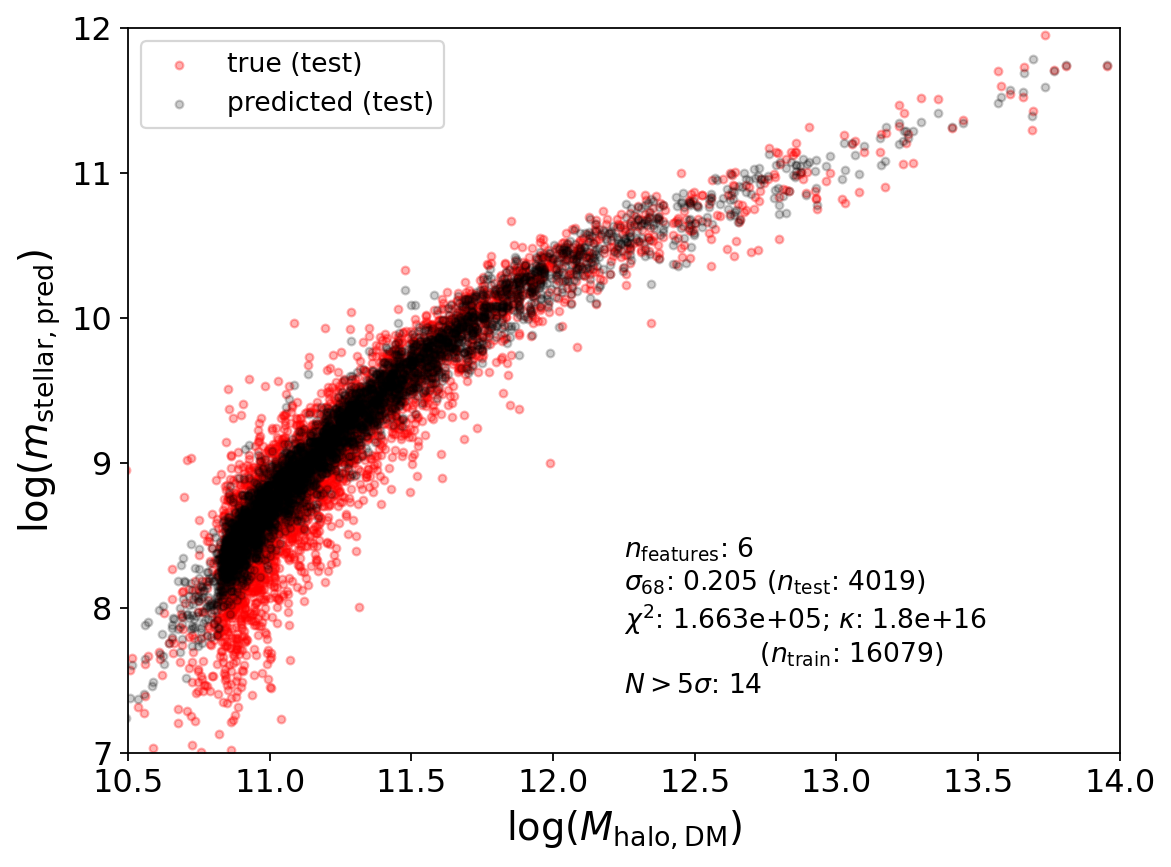

In [24]:
ones_features = np.atleast_2d(np.ones(len(log_m_stellar))).T
fitter = LinearFitter(ones_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m, log_mass_shift=log_mass_shift)

# Coarse feature importance

### mass only

In [33]:
m_order_max = 2
x_order_max = 0
v_order_max = 0
scalar_tag = f'_2bins_rescaled_mord{m_order_max}_xord{x_order_max}_vord{v_order_max}'
scalar_dir = f'../data/scalar_features/scalar_features_{sim_name}'
fn_scalar_features = f'{scalar_dir}/scalar_features{halo_tag}{geo_tag}{scalar_tag}.npy'

scalar_featurizer.load_features(fn_scalar_features)
names = [f.name for f in scalar_featurizer.scalar_feature_arr[0]]
print(names)

['g_000', 'g_001', 'g_000 g_000', 'g_000 g_001', 'g_001 g_001']


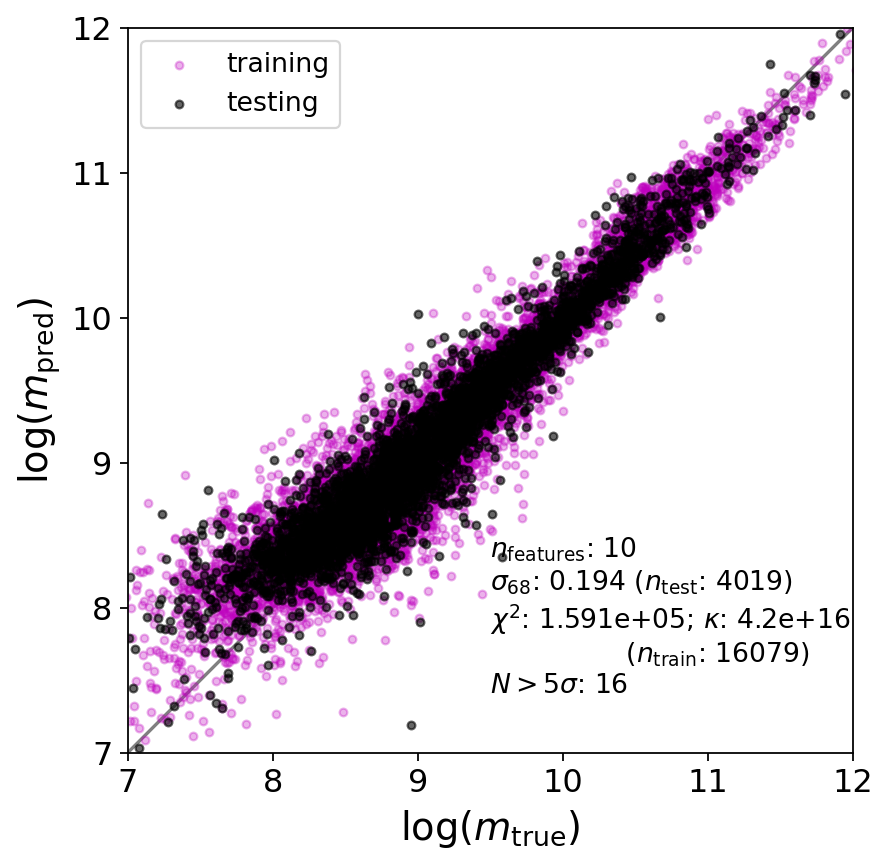

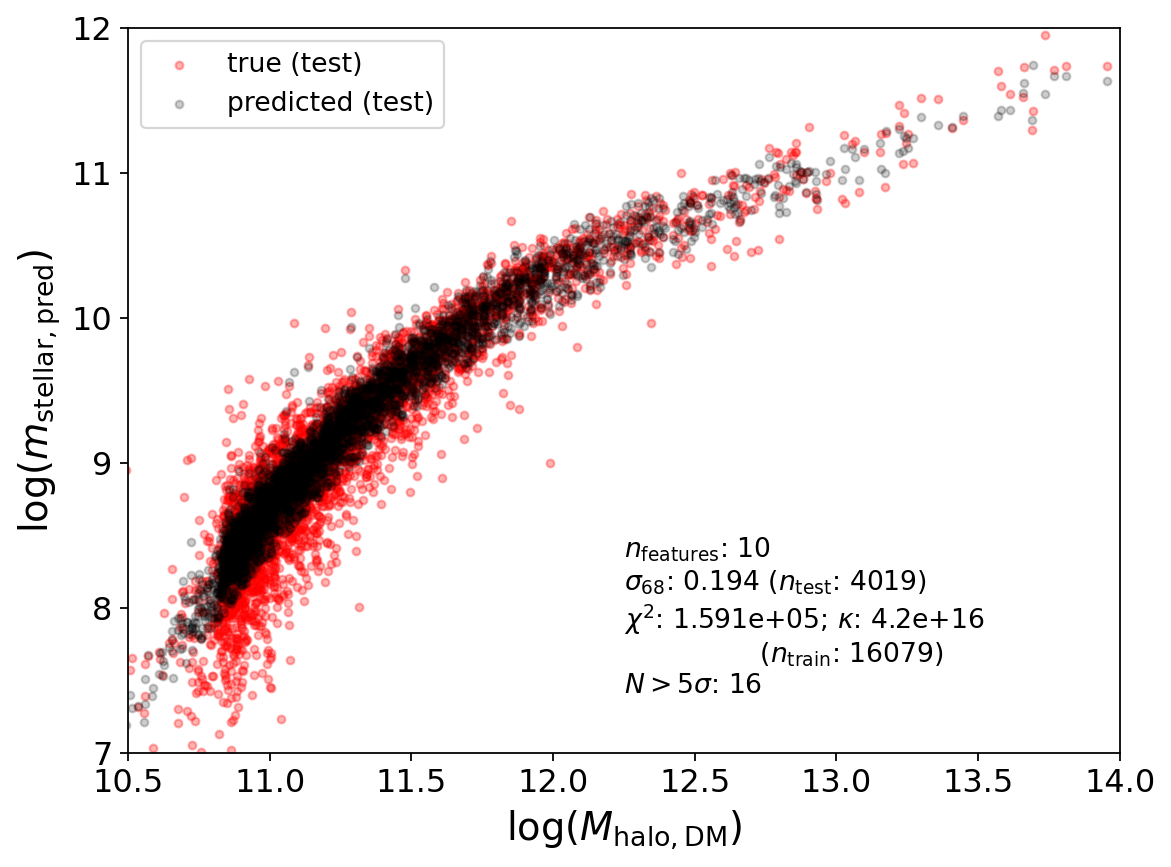

In [34]:
fitter = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m)

### mass + position

In [35]:
m_order_max = 2
x_order_max = 4
v_order_max = 0
scalar_tag = f'_2bins_rescaled_mord{m_order_max}_xord{x_order_max}_vord{v_order_max}'
scalar_dir = f'../data/scalar_features/scalar_features_{sim_name}'
fn_scalar_features = f'{scalar_dir}/scalar_features{halo_tag}{geo_tag}{scalar_tag}.npy'

scalar_featurizer.load_features(fn_scalar_features)
names = [f.name for f in scalar_featurizer.scalar_feature_arr[0]]
print(names)

['g_000', '[g_200]_jj', 'g_001', '[g_201]_jj', 'g_000 g_000', 'g_000 [g_200]_jj', 'g_000 g_001', 'g_000 [g_201]_jj', '[g_100]_j [g_100]_j', '[g_100]_j [g_101]_j', '[g_200]_jk [g_200]_jk', '[g_200]_jj [g_200]_jj', '[g_200]_jj g_001', '[g_200]_jk [g_201]_jk', '[g_200]_jj [g_201]_jj', 'g_001 g_001', 'g_001 [g_201]_jj', '[g_101]_j [g_101]_j', '[g_201]_jk [g_201]_jk', '[g_201]_jj [g_201]_jj']


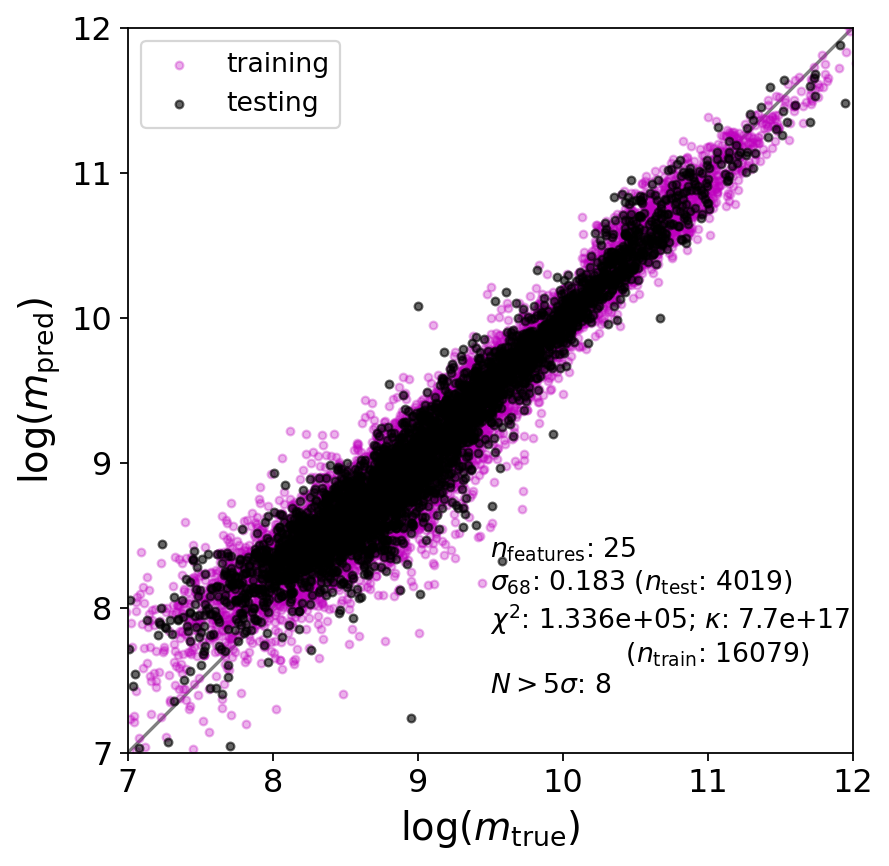

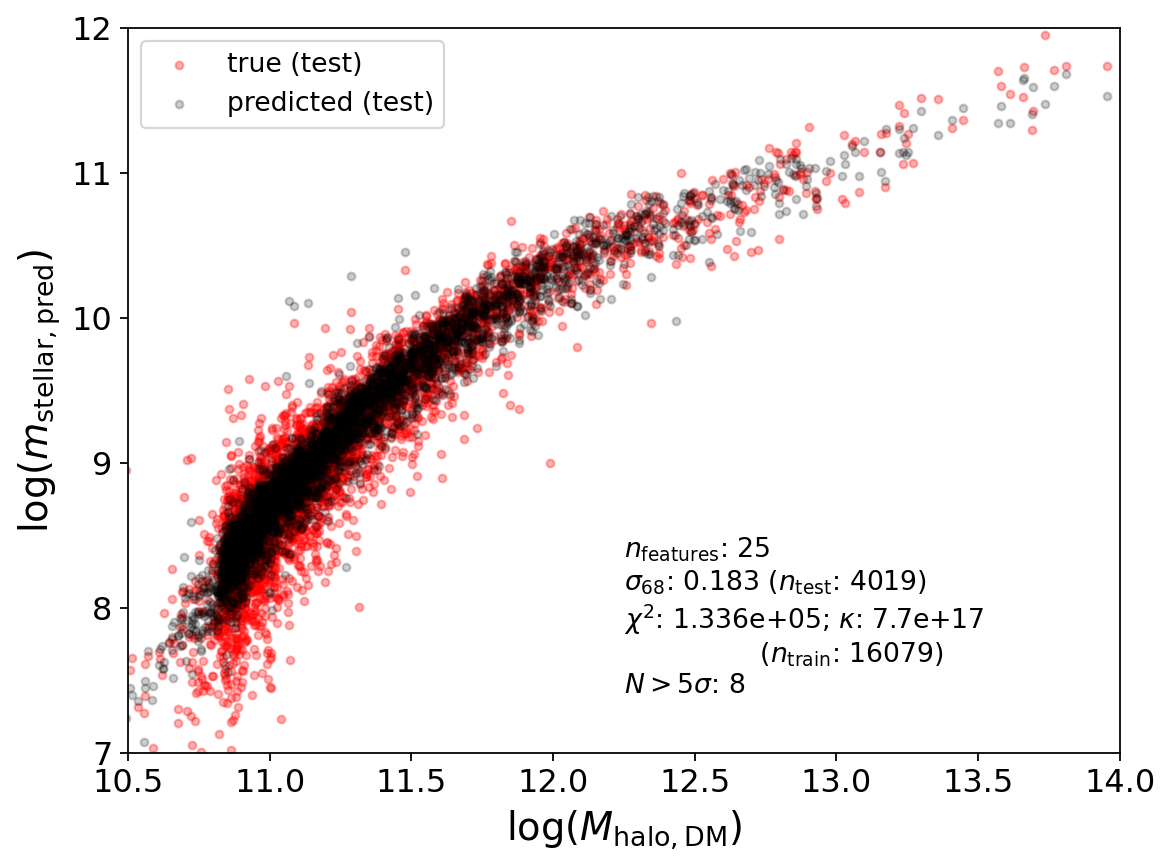

In [36]:
fitter = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m)

### mass + velocity

In [37]:
m_order_max = 2
x_order_max = 0
v_order_max = 4
scalar_tag = f'_2bins_rescaled_mord{m_order_max}_xord{x_order_max}_vord{v_order_max}'
scalar_dir = f'../data/scalar_features/scalar_features_{sim_name}'
fn_scalar_features = f'{scalar_dir}/scalar_features{halo_tag}{geo_tag}{scalar_tag}.npy'

scalar_featurizer.load_features(fn_scalar_features)
names = [f.name for f in scalar_featurizer.scalar_feature_arr[0]]
print(names)

['g_000', '[g_020]_jj', 'g_001', '[g_021]_jj', 'g_000 g_000', 'g_000 [g_020]_jj', 'g_000 g_001', 'g_000 [g_021]_jj', '[g_010]_j [g_010]_j', '[g_010]_j [g_011]_j', '[g_020]_jk [g_020]_jk', '[g_020]_jj [g_020]_jj', '[g_020]_jj g_001', '[g_020]_jk [g_021]_jk', '[g_020]_jj [g_021]_jj', 'g_001 g_001', 'g_001 [g_021]_jj', '[g_011]_j [g_011]_j', '[g_021]_jk [g_021]_jk', '[g_021]_jj [g_021]_jj']


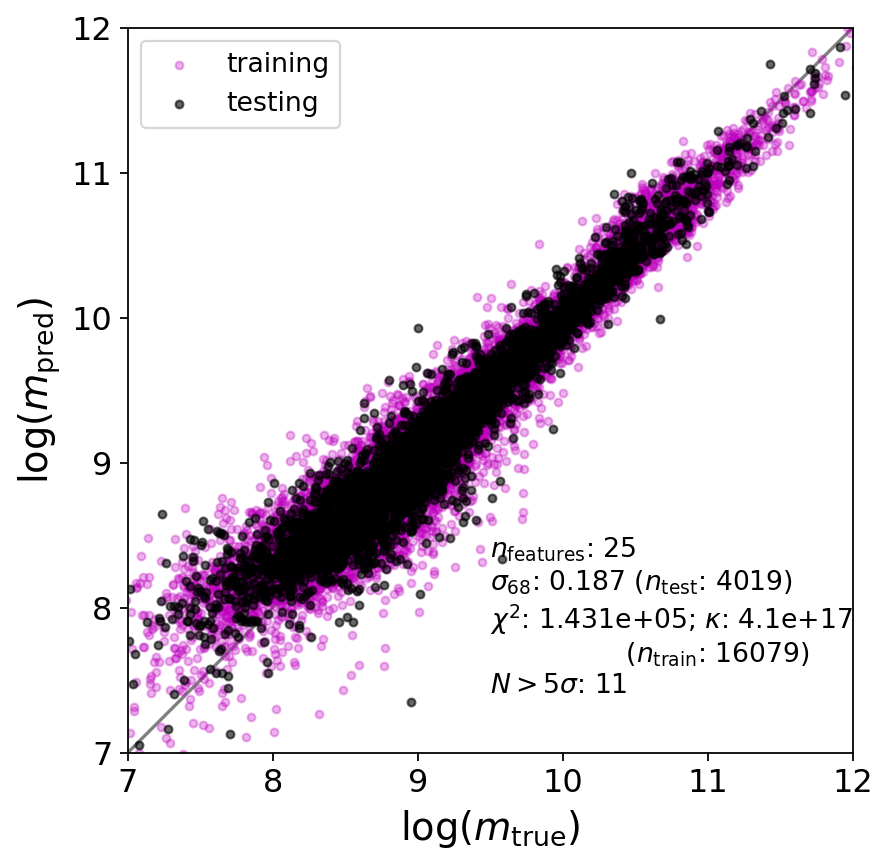

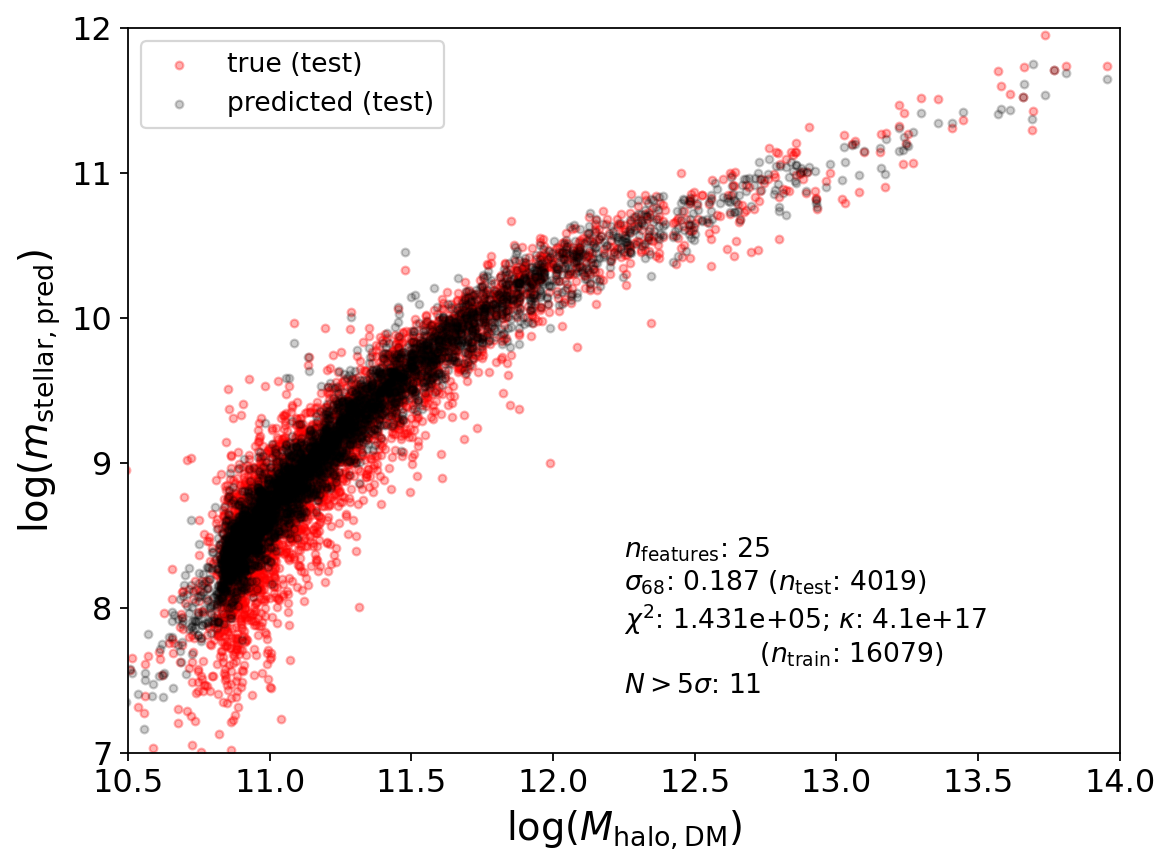

In [38]:
fitter = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m)

### mass + position + velocity

In [ ]:
m_order_max = 2
x_order_max = 4
v_order_max = 4
scalar_tag = f'_2bins_rescaled_mord{m_order_max}_xord{x_order_max}_vord{v_order_max}'
scalar_dir = f'../data/scalar_features/scalar_features_{sim_name}'
fn_scalar_features = f'{scalar_dir}/scalar_features{halo_tag}{geo_tag}{scalar_tag}.npy'

scalar_featurizer.load_features(fn_scalar_features)
names = [f.name for f in scalar_featurizer.scalar_feature_arr[0]]
print(names)

In [ ]:
fitter = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m)

In [ ]:
features_all = scalar_featurizer.scalar_features
feature_arr_all = scalar_featurizer.scalar_feature_arr

# Fine feature importance

In [37]:
N_feat = features_all.shape[1]
idxs_feat = np.array(list(range(N_feat)))
errors = np.empty(N_feat)
chi2s = np.empty(N_feat)

for idx in idxs_feat:
    features = np.delete(features_all, idx, axis=1)

    fitter = LinearFitter(features, log_m_stellar, 
                        y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                        x_features_extra=x_features_extra)
    fitter.split_train_test()
    fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
    fitter.predict_test()
    
    error, n_outliers = utils.compute_error(fitter, test_error_type='percentile')
    errors[idx] = error
    chi2s[idx] = fitter.chi2

Text(0, 0.5, '$\\chi^2$')

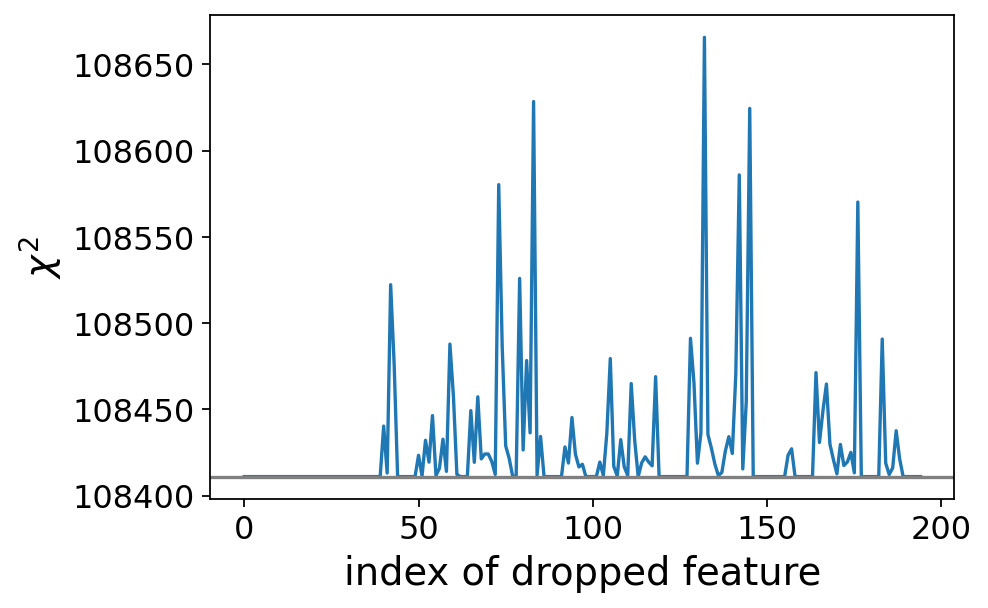

In [38]:
plt.plot(idxs_feat, chi2s)
plt.xlabel('index of dropped feature')
plt.axhline(chi2_all, color='grey', label='fit with all')
plt.ylabel('$\chi^2$')

Text(0.5, 0, 'index of dropped feature')

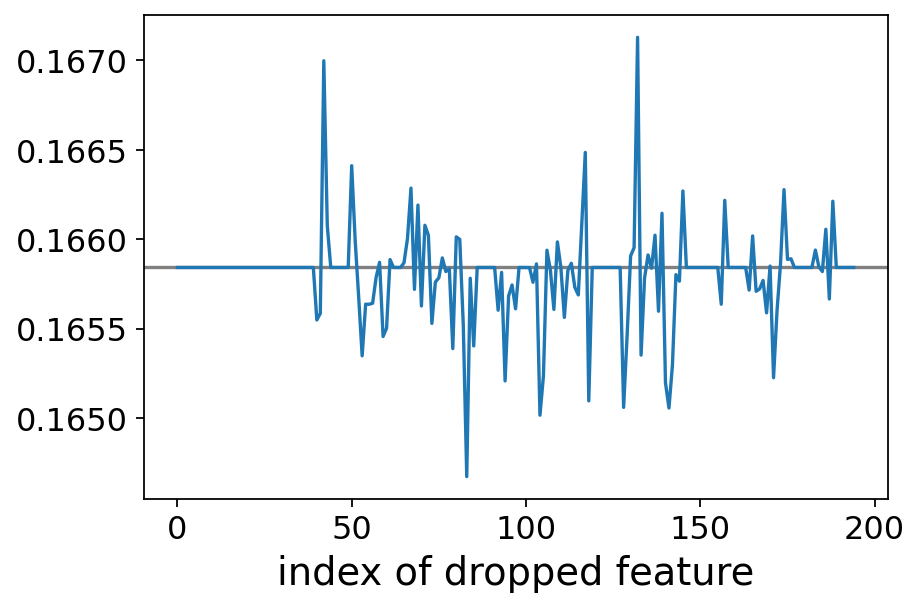

In [39]:
plt.axhline(error_all, color='grey', label='fit with all')
plt.plot(idxs_feat, errors)
plt.xlabel('index of dropped feature')

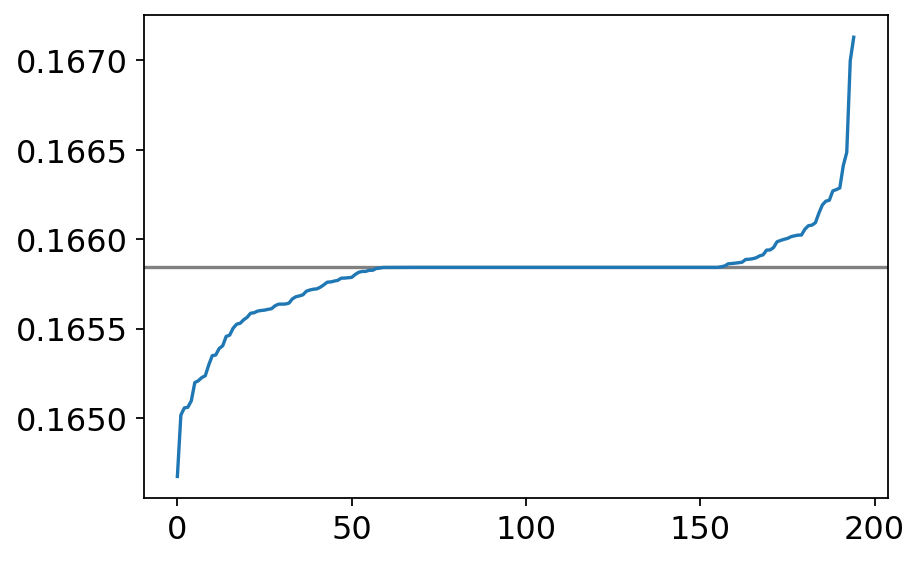

In [40]:
import scipy.stats
i_sort = np.argsort(errors)
plt.axhline(error_all, color='grey', label='fit with all')
plt.plot(errors[i_sort])
#plt.xticks(idxs_feat[i_sort])
#plt.xlabel('index of dropped feature')

In [41]:
idxs_best = idxs_feat[i_sort][::-1]

In [42]:
# 0 picks a single test sample, same features so doesn't matter which
n_print = 10
for idx_b in idxs_best[:n_print]:
    name = feature_arr_all[0][idx_b].to_string()
    print(name, errors[idx_b])

AttributeError: 'ScalarFeature' object has no attribute 'name'

### Investigate features that don't change outcome when dropped

In [ ]:
idxs_flat = np.argsort(np.abs(errors - error_all))

In [ ]:
# 0 picks a single test sample, same features so doesn't matter which
for idx_f in idxs_flat[:n_print]:
    name = feature_arr_all[0][idx_f].to_string()
    print(name, error)

In [ ]:
# 0 picks a single test sample, same features so doesn't matter which
idxs_matches = []
for idx_f in idxs_flat[:2]:
    feat = features_all[idx_f]
    feats_other = np.delete(features, idx_f, axis=1)
    idxs_matches_per_idxflat = []
    for i in range(features_all.shape[1]):
        if i==idx_f:
            continue
        if np.all_close(feat, features_all[:,i]):
            idxs_matches_per_idxflat.append(i)
    idxs_matches.append(idxs_matches_per_idxflat)

In [ ]:
idx_best_top = idxs_best[:50]
fitter = LinearFitter(features_all[:,idx_best_top], log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
error_all, n_outliers_all = utils.compute_error(fitter, test_error_type='percentile')
chi2_all = fitter.chi2
plotter.plot_fits(fitter, log_m_200m)

### Now let's drop one at a time starting from the worst feature!